## Supervised and Unsupervised Learning for Country Classification
### Dataset used: Electrical-Energy
##### Link to download : http://data.un.org/Data.aspx?d=ICS&f=cmID%3a17100-0


In [83]:
#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

# libraries for computation
import pandas as pd
import numpy as np

#library for train test split
from sklearn.model_selection import train_test_split,cross_val_score,KFold

#library for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#library for Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#Library for feature selection techniques
from sklearn.feature_selection import RFE

#libraries for various ML models 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
#ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#Libraries for Unsupervised learning
from sklearn.cluster import KMeans,AgglomerativeClustering

#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

In [84]:
# Utility Method to plot confusion matrix
def plotConfusionMatrix(cm):
    sns.set_style('white')
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
    classNames = ['Developed','Developing']
    plt.title('Confusion Matrix',fontsize = 15)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames,fontsize=12)
    plt.yticks(tick_marks, classNames,fontsize=12)
    s = [['TP','FN'], ['FP', 'TN']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

### Read Data from CSV

In [85]:
# Read data from csv and print the head
data = pd.read_csv('Electrical-Energy.csv')
data.head(5)

,Country or Area,Year,Unit,Value,Value Footnotes
0,Afghanistan,2015,Million kWh,1033.69,1.0
1,Afghanistan,2014,Million kWh,1049.30,1.0
2,Afghanistan,2013,Million kWh,1022.29,1.0
3,Afghanistan,2012,Million kWh,1022.00,1.0
4,Afghanistan,2011,Million kWh,1005.00,1.0


#### lets drop extra column Value Footnotes

In [86]:
# Read data from csv and print the head
data = data.drop(columns=['Unit','Value Footnotes'])
data.head(5)

,Country or Area,Year,Value
0,Afghanistan,2015,1033.69
1,Afghanistan,2014,1049.30
2,Afghanistan,2013,1022.29
3,Afghanistan,2012,1022.00
4,Afghanistan,2011,1005.00


#### Get data insights

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4594 entries, 0 to 4593
Data columns (total 3 columns):
Country or Area    4594 non-null object
Year               4594 non-null object
Value              4589 non-null float64
dtypes: float64(1), object(2)
memory usage: 107.8+ KB


#### It seems Value column has some null or Nan values

In [88]:
vals = data['Value']
d = data[ vals.isna() ]
d

,Country or Area,Year,Value
4589,fnSeqID,Footnote,NaN
4590,1,Twelve months beginning 21 March of year stated.,NaN
4591,2,Twelve months ending 30 June of year stated.,NaN
4592,3,Twelve months beginning 1 April of year stated.,NaN
4593,4,Twelve months beginning 1 July of year stated.,NaN


##### lets drop this rows

In [89]:
data  = data [0:4589] 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4589 entries, 0 to 4588
Data columns (total 3 columns):
Country or Area    4589 non-null object
Year               4589 non-null object
Value              4589 non-null float64
dtypes: float64(1), object(2)
memory usage: 107.6+ KB


In [90]:
#lets check number of unique countries we have in dataset
data['Country or Area'].nunique()

225

### Lets normalize data

In [91]:
# Normalize the value column and drop old column

# Create x, where x the 'Value' column's values as floats
x = data[['Value']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
df_normalized['normalized'] = pd.DataFrame(x_scaled)
df_normalized.drop(columns=0,inplace=True)

data_new = pd.concat([data,df_normalized ], axis=1)
data_new.drop(columns='Value',inplace=True)

In [92]:
# Check new dataframe with normalized value
data_new.head()

,Country or Area,Year,normalized
0,Afghanistan,2015,0.000177
1,Afghanistan,2014,0.000180
2,Afghanistan,2013,0.000175
3,Afghanistan,2012,0.000175
4,Afghanistan,2011,0.000172


#### Using tsfresh to extract features from data

In [93]:
# Use TSFresh library to extract features from data 
from tsfresh import extract_features
extracted_features = extract_features(data_new, column_id="Country or Area", column_sort="Year")

Feature Extraction: 100%|██████████| 10/10 [00:21<00:00,  1.97s/it]


In [94]:
#Check extracted features
extracted_features.head()

variable,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,normalized__time_reversal_asymmetry_statistic__lag_1,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4.491792e-07,0.000169,-0.521479,-0.439646,0.754176,0.000162,0.804879,0.000010,0.000007,NaN,...,2.915880e-13,6.304901e-13,9.491453e-13,0.0,0.0,0.0,0.0,0.0,5.776580e-10,0.0
Albania,1.656073e-05,0.004046,-0.047270,-0.024494,0.066182,0.001124,-0.014640,-0.000003,0.000182,NaN,...,7.407445e-12,3.273302e-11,9.160711e-11,0.0,0.0,0.0,0.0,0.0,3.426001e-08,0.0
Algeria,9.959577e-04,0.009038,-0.606782,-0.440152,1.048002,0.006189,0.916244,0.003229,0.001412,NaN,...,1.020390e-07,1.876649e-07,2.499930e-07,0.0,0.0,0.0,0.0,0.0,6.421800e-06,0.0
American Samoa,1.723640e-08,0.000018,0.000000,0.000000,0.000000,0.000033,-0.849867,-0.000002,0.000001,NaN,...,5.559242e-16,7.322849e-16,5.772164e-16,0.0,0.0,0.0,0.0,0.0,7.536334e-12,0.0
Andorra,5.248735e-09,0.000036,0.000000,0.000000,0.000000,0.000022,-0.815853,-0.000002,0.000001,NaN,...,-5.587890e-17,1.835030e-17,3.322394e-16,0.0,0.0,0.0,0.0,0.0,7.443494e-12,0.0


In [95]:
#Check shape of new data with extracted features
extracted_features.shape

(225, 794)

In [96]:
#Check if any columns contains Nan values (null values)
list_cols_with_nan = extracted_features.columns[extracted_features.isna().any()].tolist()
len(list_cols_with_nan)

509

In [97]:
# it seems 552 columns out of 794 have some null values

In [98]:
#lets replace nan value with 0.0
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
data_after_impute = impute(extracted_features)

 'normalized__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'normalized__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'normalized__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'normalized__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'normalized__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'normalized__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'normalized__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'normalized__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'normalized__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'normalized__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'normalized__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'normalized__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'normalized__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'normalized__agg_linear_tre

In [99]:
#lets check if any column has any nan value
list_cols_with_nan_after_impute = data_after_impute.columns[data_after_impute.isna().any()].tolist()
len(list_cols_with_nan_after_impute)

0

In [100]:
#we dont have any nan values 
# lets reset the index
data_after_impute = data_after_impute.reset_index()

In [101]:
# we need to give labels to countries 
data_countries = pd.read_excel('Developing countries.xlsx')

developed_countries = data_countries [data_countries['Value'] == 0]
developing_countries = data_countries [data_countries['Value'] == 1] 

list_developed_countries = developed_countries['Countries']
list_developing_countries = developing_countries['Countries']

list_developed_countries = list(list_developed_countries)
list_developing_countries = list(list_developing_countries)

data_after_impute['label'] = -1

for i,da in data_after_impute.iterrows():
    if da['id'] in list_developed_countries:
        val = 0
        data_after_impute.at[i,'label'] = val
    elif da['id'] not in list_developed_countries:
        val = 1
        data_after_impute.at[i,'label'] = val

In [102]:
# check new df with added column as label 
data_after_impute.head()

variable,id,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""",...,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation,label
0,Afghanistan,4.491792e-07,0.000169,-0.521479,-0.439646,0.754176,0.000162,0.804879,0.000010,0.000007,...,6.304901e-13,9.491453e-13,0.0,0.0,0.0,0.0,0.0,5.776580e-10,0.0,1
1,Albania,1.656073e-05,0.004046,-0.047270,-0.024494,0.066182,0.001124,-0.014640,-0.000003,0.000182,...,3.273302e-11,9.160711e-11,0.0,0.0,0.0,0.0,0.0,3.426001e-08,0.0,1
2,Algeria,9.959577e-04,0.009038,-0.606782,-0.440152,1.048002,0.006189,0.916244,0.003229,0.001412,...,1.876649e-07,2.499930e-07,0.0,0.0,0.0,0.0,0.0,6.421800e-06,0.0,1
3,American Samoa,1.723640e-08,0.000018,0.000000,0.000000,0.000000,0.000033,-0.849867,-0.000002,0.000001,...,7.322849e-16,5.772164e-16,0.0,0.0,0.0,0.0,0.0,7.536334e-12,0.0,1
4,Andorra,5.248735e-09,0.000036,0.000000,0.000000,0.000000,0.000022,-0.815853,-0.000002,0.000001,...,1.835030e-17,3.322394e-16,0.0,0.0,0.0,0.0,0.0,7.443494e-12,0.0,1


In [103]:
#Split data into X(features),y 
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])
y.value_counts()

1    195
0     30
Name: label, dtype: int64

In [111]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=54)
y_test.value_counts()

1    75
0    15
Name: label, dtype: int64

## Supervised learning techniques

#### Support Vector Machine

In [112]:
clf = svm.SVC(gamma='auto',C=10,kernel='rbf')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))

Area Under Curve:  0.5


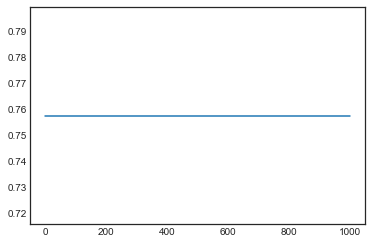

In [113]:
#SVM Fine tunning
cVals = [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
f1_scores = []
for c in cVals:
    clf = svm.SVC(gamma='auto',C=c,kernel='rbf')
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(cVals,f1_scores)

#### Output with best parameters for SVM

In [114]:
clf = svm.SVC(gamma='auto',C=0.001,kernel='rbf')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))

Area Under Curve:  0.5


##### We can see from confusion matrix that SVM does very poor job and recognizes all countries in test set as developing.
##### Recall precision and F1 score for developed countries is 0.00

#### Logistic Regression

Area Under Curve:  0.5800000000000001
             precision    recall  f1-score   support

          0       0.23      0.47      0.31        15
          1       0.87      0.69      0.77        75

avg / total       0.76      0.66      0.69        90



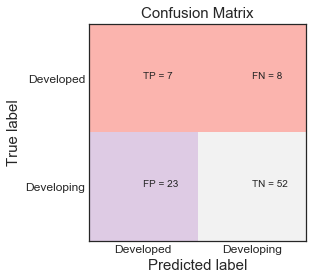

In [115]:
#Logistic Regression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
pred = logmodel.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

###### KNN with k ranging from 1 to 15

Text(0.5,0,'K values')

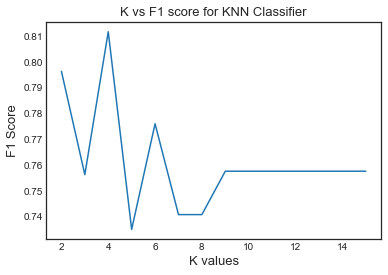

In [27]:
#KNN for different k values
kVals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(kVals,scores)
plt.title('K vs F1 score for KNN Classifier',fontsize = 13)
plt.ylabel('F1 Score',fontsize=13)
plt.xlabel('K values',fontsize=13)

#### Output with best value of K

Area Under Curve:  0.6066666666666667
             precision    recall  f1-score   support

          0       0.50      0.27      0.35        15
          1       0.87      0.95      0.90        75

avg / total       0.80      0.83      0.81        90



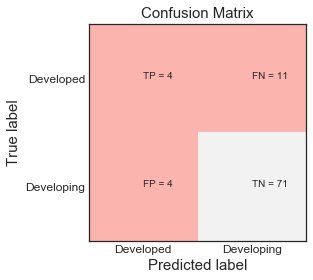

In [116]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Decision Tree Classifier

Area Under Curve:  0.66
             precision    recall  f1-score   support

          0       0.50      0.40      0.44        15
          1       0.88      0.92      0.90        75

avg / total       0.82      0.83      0.83        90



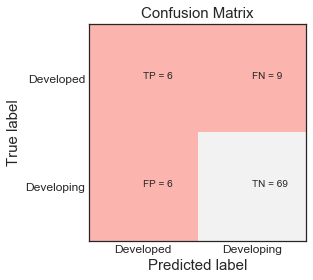

In [117]:
#DT
d_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
d_classifier.fit(X_train,y_train)
pred = d_classifier.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Bagging Classifier with Decision Tree as base estimator

[0.802336028751123, 0.8034188034188035, 0.8116865134311826, 0.8116865134311826, 0.8034188034188035, 0.8116865134311826, 0.8116865134311826, 0.8116865134311826, 0.8116865134311826, 0.8200997314921364, 0.8200997314921364, 0.8200997314921364]


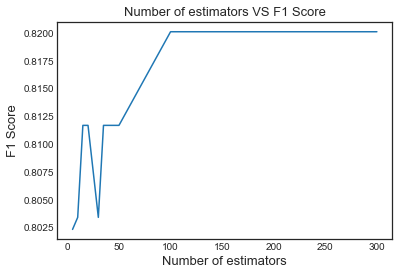

In [30]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    cart = DecisionTreeClassifier()
    model = BaggingClassifier(base_estimator=cart, n_estimators=e, random_state=7)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

Area Under Curve:  0.6133333333333333
             precision    recall  f1-score   support

          0       0.57      0.27      0.36        15
          1       0.87      0.96      0.91        75

avg / total       0.82      0.84      0.82        90



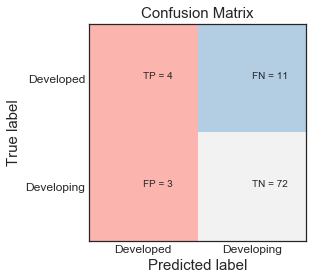

In [118]:
#Bagging Classifier with Decision tree as base learner
cart = DecisionTreeClassifier()
model = BaggingClassifier(base_estimator=cart, n_estimators=150, random_state=7)
model.fit(X_train, y_train)
pred = model.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Random Forest Classifier

#### Fine tuninng Random Forest for different number of estimators

[0.7686996547756042, 0.7952688172043011, 0.7686996547756042, 0.7788461538461537, 0.75625, 0.75625, 0.75625, 0.75625, 0.75625, 0.7686996547756042, 0.7759808325846063, 0.7759808325846063]


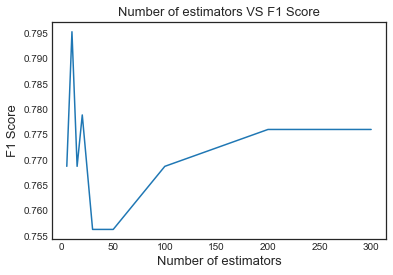

In [32]:
#Ensemble Random Forest Classifier Fine Tunning
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    rf_classifier = RandomForestClassifier(n_estimators=e, random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### Lets fine tune for number of features with best number of estimator from above analysis

In [119]:
rf_classifier = RandomForestClassifier(n_estimators=10, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))

Area Under Curve:  0.5933333333333334


[0.7833333333333333, 0.7759808325846063, 0.7686996547756042, 0.8034188034188035, 0.7865780485553401, 0.7865780485553401, 0.8193548387096773, 0.8034188034188035, 0.7686996547756042, 0.8116865134311826, 0.8116865134311826]


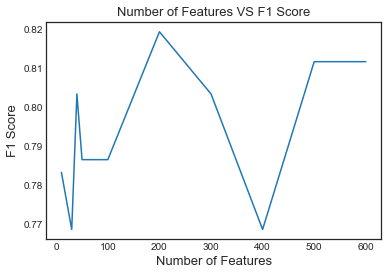

In [34]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    rf_classifier = RandomForestClassifier(max_features = e ,n_estimators=100,random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores)
plt.title("Number of Features VS F1 Score",fontsize = 13)
plt.xlabel('Number of Features',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### RFC with Best Parameters

In [120]:
rf_classifier = RandomForestClassifier(n_estimators=100,max_features=200, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))

Area Under Curve:  0.6333333333333333
             precision    recall  f1-score   support

          0       0.50      0.33      0.40        15
          1       0.88      0.93      0.90        75

avg / total       0.81      0.83      0.82        90



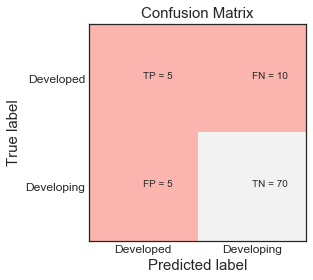

In [121]:
plotConfusionMatrix(confusion_matrix(y_test,pred))

### Extra tree classifier

###### Fine tune for number of estimators

[0.7614695836794978, 0.802469135802469, 0.8034188034188035, 0.7872127872127872, 0.7542735042735043, 0.7542735042735043, 0.7614695836794978, 0.7614695836794978, 0.7614695836794978, 0.7496256364180892, 0.7496256364180892, 0.75625]


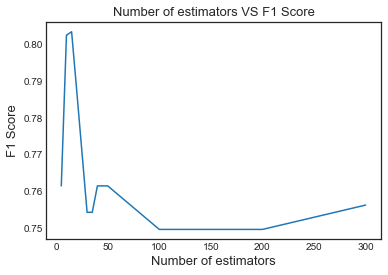

In [65]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    model = ExtraTreesClassifier(n_estimators=e,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

In [122]:
model = ExtraTreesClassifier(n_estimators=10,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))

Area Under Curve:  0.62


#### fine tune for max_features

[0.827991452991453, 0.8034188034188035, 0.8193548387096773, 0.7711827956989248, 0.7865780485553401, 0.827991452991453, 0.8310116464946334, 0.802469135802469, 0.7943996931338703, 0.8193548387096773, 0.8344988344988343]


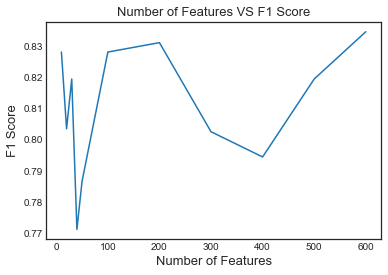

In [68]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    model = ExtraTreesClassifier(max_features=e,n_estimators=10,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores) 
plt.title("Number of Features VS F1 Score",fontsize = 13)
plt.xlabel('Number of Features',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### Best ExtraTree Classifier

In [123]:
model = ExtraTreesClassifier(n_estimators=10,max_features=600,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
fpr,tpr,thresholds = metrics.roc_curve(y_test,pred)
print("Area Under Curve: ",metrics.auc(fpr,tpr))
print(classification_report(y_test,pred))

Area Under Curve:  0.6666666666666667
             precision    recall  f1-score   support

          0       0.55      0.40      0.46        15
          1       0.89      0.93      0.91        75

avg / total       0.83      0.84      0.83        90



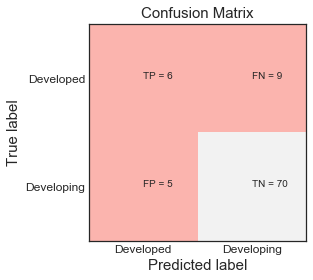

In [124]:
plotConfusionMatrix(confusion_matrix(y_test,pred))

### Treating problem as Unsupervised learning

In [71]:
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])

### K-Means Clustering

             precision    recall  f1-score   support

          0       0.13      1.00      0.24        30
          1       1.00      0.01      0.02       195

avg / total       0.88      0.14      0.05       225



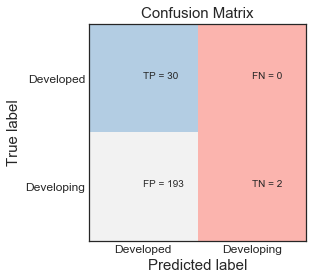

In [72]:
#Build model for k-means clustering
model = KMeans(n_clusters=2,n_init=400,random_state=42,max_iter=1000)
model.fit(X)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

### Lets do principal component analysis and Singular Value Decomposition

#### First standardize data and then perform PCA

#### Lets plot 2-D graph and check how points are distributed

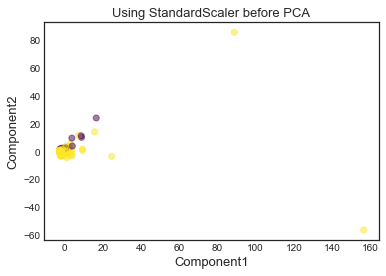

In [73]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using StandardScaler before PCA',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

#### How does it look in 3D

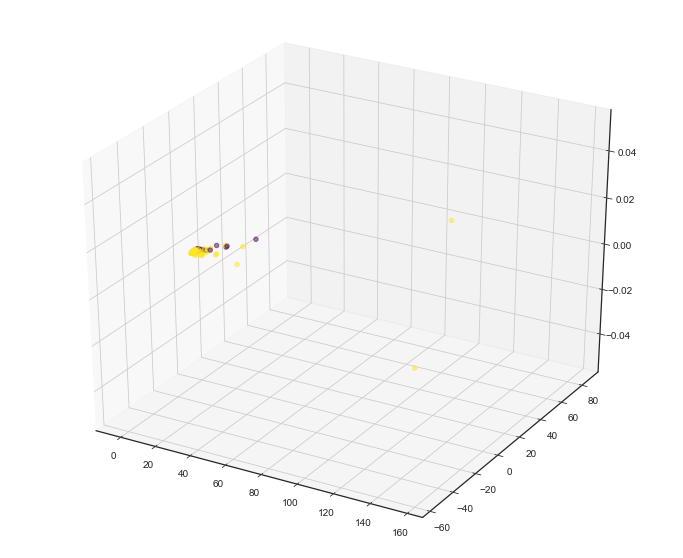

In [74]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

##  SVD

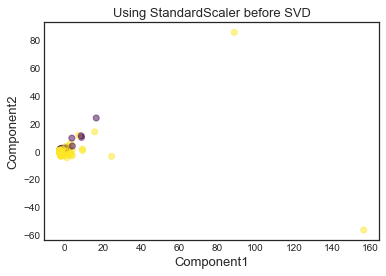

In [75]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using StandardScaler before SVD',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

#### SVD is same as PCA

#### Lets check how data looks if we do min max scaling and then PCA

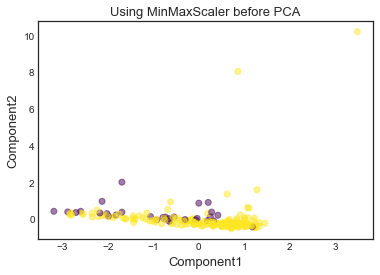

In [76]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using MinMaxScaler before PCA',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

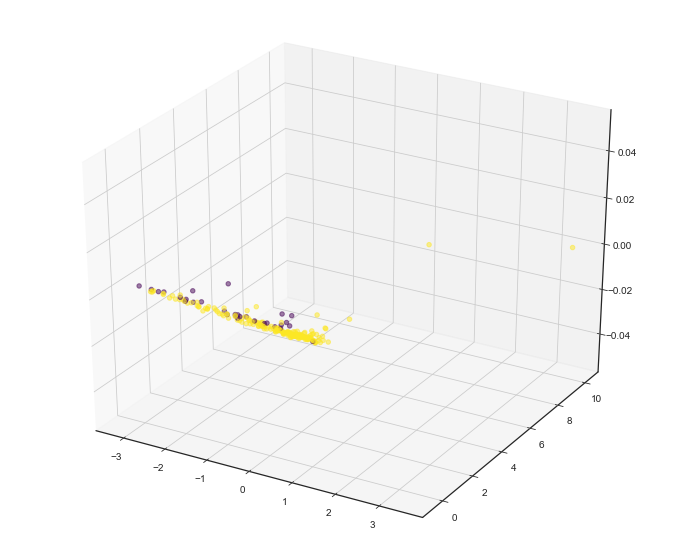

In [77]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

#### SVD with minmaxscaling

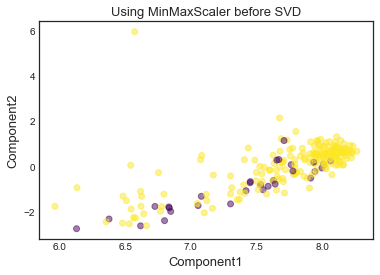

In [78]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using MinMaxScaler before SVD',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

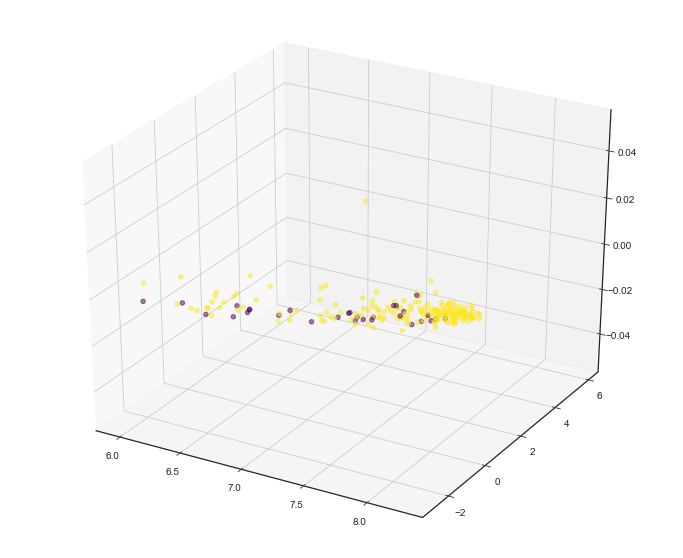

In [79]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

In [80]:
#Utility function to perform clustering with different algos, dimensionality reduction, different number of components
def testFunctions(algo,scaling,drTechnique,dimensions,X,y_arr):
    if scaling == 'Standard':
        scaler = StandardScaler()
    elif scaling == 'MinMax':
        scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(X)
    scaled_df = pd.DataFrame(scaled_df)
    
    if drTechnique == 'PCA':
        pca = PCA(n_components=dimensions)  
        X_pca = pca.fit_transform(scaled_df)
    elif drTechnique == 'SVD':
        pca = TruncatedSVD(n_components=dimensions)  
        X_pca = pca.fit_transform(scaled_df)
        
    if algo == 'KMeans':
        model = KMeans(n_clusters=2,n_init=100,random_state=42,precompute_distances=True,max_iter=1000)
    elif algo == 'AggClustering':
        model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
        
    model.fit(X_pca)
    y_pred = model.labels_
    score = f1_score(y_pred,y_arr,average='weighted')
    return score

## K Means

lets check f1 scores for different number of principal components

[0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078]


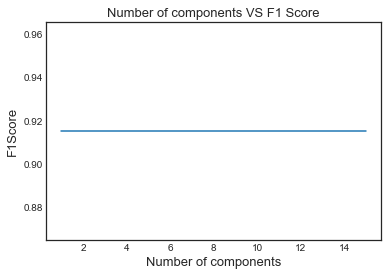

In [81]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','Standard','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.734492570258587, 0.734492570258587, 0.734492570258587, 0.1784704184704185, 0.7422074566260612, 0.7422074566260612, 0.7422074566260612, 0.7422074566260612, 0.7422074566260612, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786]


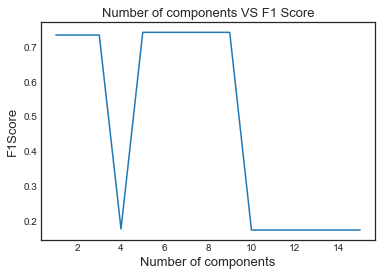

In [82]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','MinMax','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.7570587309085184, 0.7234842324026386, 0.734492570258587, 0.734492570258587, 0.17800387596899225, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786, 0.17547907754798786]


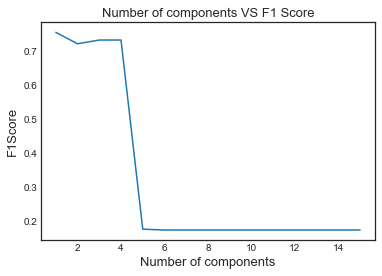

In [54]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','MinMax','SVD',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

#### Best results for K Means 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        30
          1       0.87      0.99      0.92       195

avg / total       0.75      0.86      0.80       225



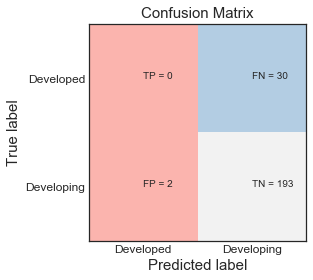

In [55]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)
model = KMeans(n_clusters=2,n_init=100,random_state=42,precompute_distances=True,max_iter=1000)
model.fit(X_pca)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

#### Lets see how did K-Means clustering performed and compare original points vs predicted points

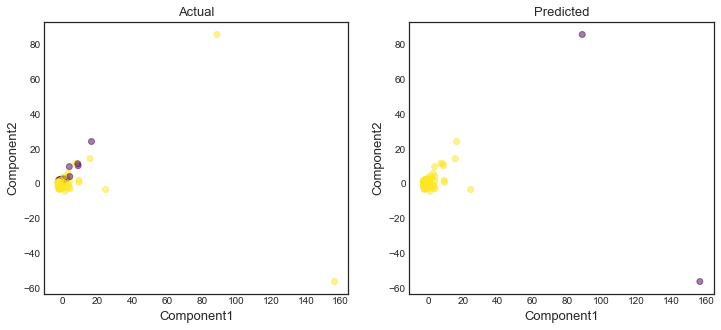

In [56]:
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Actual',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)

plt.subplot(1,2,2)
plt.scatter(a,b,alpha=0.5,c=y_pred,cmap='viridis')
plt.title('Predicted',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

## Agglomerative Clustering

[0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078, 0.9152365762892078]


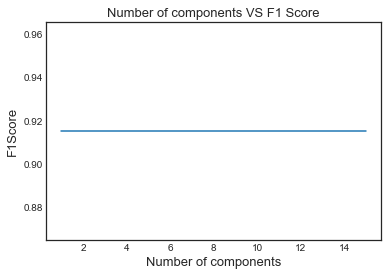

In [57]:
# Standardscaling + PCA
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','Standard','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.1688888888888889, 0.18038545928956887, 0.1715724999494633, 0.18839035516454872, 0.17577421815408084, 0.2352265983605644, 0.2352265983605644, 0.16205366971649252, 0.17577421815408084, 0.2352265983605644, 0.1961174713787954, 0.1694750414440965, 0.1793037391784859, 0.1795729737322658, 0.1795729737322658]


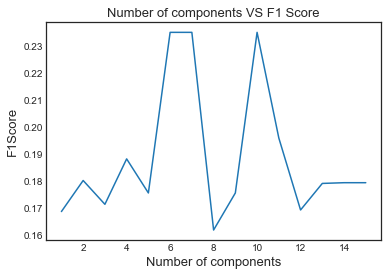

In [58]:
## MinMaxScaling + PCA
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','MinMax','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.19376352015732548, 0.18531899244973993, 0.17248265432220705, 0.17485380116959062, 0.18150679159727937, 0.19336693370116895, 0.19810345861056167, 0.2352265983605644, 0.2352265983605644, 0.17577421815408084, 0.1793037391784859, 0.1961174713787954, 0.18647880767045258, 0.1777777777777778, 0.171933771615961]


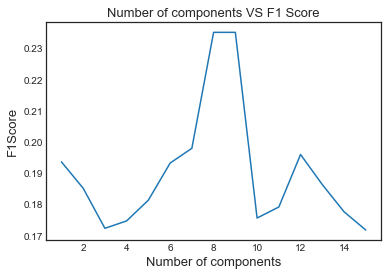

In [59]:
# MinMax Scaling + SVD
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','MinMax','SVD',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

#### Using best parameters for Agg clustering

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        30
          1       0.87      0.99      0.92       195

avg / total       0.75      0.86      0.80       225



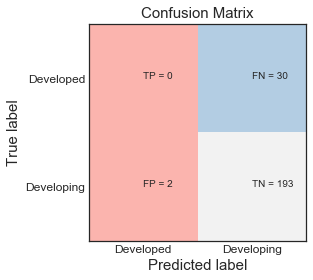

In [60]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(X_pca)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

#### Lets see how did Agglomerative clustering performed and compare original points vs predicted points

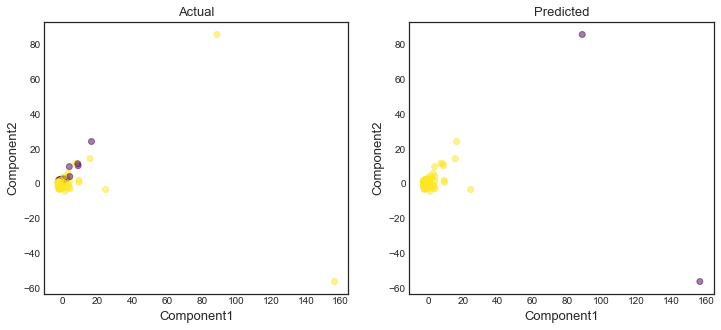

In [61]:
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Actual',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)

plt.subplot(1,2,2)
plt.scatter(a,b,alpha=0.5,c=y_pred,cmap='viridis')
plt.title('Predicted',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()